## Required Modules

In [1]:
import os
from zipfile import ZipFile
import pickle
import bz2
import json

import numpy.testing as npt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Set Global Filepaths and Methods

In [2]:
# expected file paths
DATA_ROOT_DIRECTORY: str = 'data'
COMPRESSED_DATA_DIRECTORY_PATH: str = os.path.join(DATA_ROOT_DIRECTORY, 'compressed')
COMPRESSED_MANIFEST_FILE_PATH: str = os.path.join(COMPRESSED_DATA_DIRECTORY_PATH, 'shipnet_manifest.pbz2')
COMPRESSED_IMAGES_FILE_PATH: str = os.path.join(COMPRESSED_DATA_DIRECTORY_PATH, 'shipnet_images.zip')

# file paths to create
UNCOMPRESSED_DATA_DIRECTORY_PATH: str = os.path.join(DATA_ROOT_DIRECTORY, 'uncompressed')
UNCOMPRESSED_MANIFEST_FILE_PATH: str = os.path.join(UNCOMPRESSED_DATA_DIRECTORY_PATH, 'shipnet.json')
UNCOMPRESSED_IMAGES_DIRECTORY_PATH: str = os.path.join(UNCOMPRESSED_DATA_DIRECTORY_PATH, 'shipnet')
    
def get_full_path(local_path: str):
    """
    Gets the full path from the local path.

    :param local_path: a string pointing to a path local to this Notebook
    :returns: a string pointing to the full path corresponding to the provided local path
    """
    return os.path.join(os.getcwd(), local_path)

def raise_file_not_found_error_for_path(expected_object: str, local_path: str):
    """
    Raises a descriptive file not found error using the provided

    :param expected_object: a string fragment describing the content of the expected file
    :param local_path: the path that was not found
    :return: None.
    :raises FileNotFoundError
    """
    raise FileNotFoundError(f'Could not find {expected_object} at the specified path: {get_full_path(local_path)}')

## Unzipping Data 

We need to compress the data in order to store it in GitHub. 

We will use the following modules:
 - __zipfile__ to decompress the archive of the training images
 - __pickle__ and __bz2__ to decompress the JSON object containing the manifest of images and their lables
 - __os__ to handle filepath and directory manipulation
 - __json__ to read / write JSON manifest
 

In [3]:
def deflate_manifest():
    """
    Deflates the compressed manifest file using bz2 decompression. Note this will create a ~350 MB file in the
    UNCOMPRESSED_DATA_DIRECTORY_PATH.

    :return: None.
    """
    with bz2.BZ2File(COMPRESSED_MANIFEST_FILE_PATH, 'rb') as input_file:
        with open(UNCOMPRESSED_MANIFEST_FILE_PATH, 'w') as output_file:
            json.dump(pickle.load(input_file), output_file)
    return None


def deflate_images():
    """
    Deflates the compressed images file using zip decompression. Note this will create 4000 images in the
    UNCOMPRESSED_IMAGES_DIRECTORY_PATH directory.

    :return: None.
    """
    with ZipFile(COMPRESSED_IMAGES_FILE_PATH, 'r') as input_file:
        input_file.extractall(UNCOMPRESSED_IMAGES_DIRECTORY_PATH)
    return None


def check_and_deflate_all():
    """
    Checks for expected input files and a non-existent UNCOMPRESSED_DATA_DIRECTORY_PATH directory, then
    deflates the manifest and images. 

    :raises FileNotFoundError if expected input files are not found
    :raises FileExistsError if UNCOMPRESSED_DATA_DIRECTORY_PATH exists
    :returns: None.
    """

    # check if compressed data directory exists
    if os.path.isdir(COMPRESSED_DATA_DIRECTORY_PATH):

        # if so, check for compressed manifest file
        if not os.path.isfile(COMPRESSED_MANIFEST_FILE_PATH):
            raise_file_not_found_error_for_path('the compressed manifest file', COMPRESSED_MANIFEST_FILE_PATH)

        # and compressed images file
        if not os.path.isfile(COMPRESSED_IMAGES_FILE_PATH):
            raise_file_not_found_error_for_path('the compressed images file', COMPRESSED_IMAGES_FILE_PATH)

    else:
        raise raise_file_not_found_error_for_path('the compressed data directory', COMPRESSED_DATA_DIRECTORY_PATH)

    # check if uncompressed data directory exists
    if os.path.isdir(UNCOMPRESSED_DATA_DIRECTORY_PATH):
        raise FileExistsError(('The path to the output directory already exists: '
                               f'{get_full_path(UNCOMPRESSED_DATA_DIRECTORY_PATH)}. If you are sure you want to run this step '
                               'please remove this directory manually - we will not overwrite it.'))

    # inflate files
    else:
        os.mkdir(UNCOMPRESSED_DATA_DIRECTORY_PATH)
        deflate_manifest()
        deflate_images()

    return None

In [4]:
check_and_deflate_all()

## Load & Visually Inspect Data 
   - Note the previous step only needs to be run once to generate __/data/uncompressed__. 
   - In this step we will read in the data and check it against the manifest.
 

### Load in Manifest
This should match the shipsnet.json file from https://www.kaggle.com/rhammell/ships-in-satellite-imagery/. 

The manifest JSON is expected to contain the following key-value mappings:

  - __data__: 4000 vectors of length 19200, representing 80 x 80 pixel images with 3 color channels (RGB)
  - __labels__: a vector of length 4000 with 1 if the corresponding image in __data__ is a ship, and 0 if it is not a ship.
  - __scene__: a vector of length 4000 specifying the scene the corresponding image in __data__ was extracted from 
  - __locations__: a vector of dimension 4000 x 2 containing the longitude and latitude (unspecified, presumed WGS 84) of the the centerpoint of the corresponding image in __data__ 

In [5]:
# read in the manifest
with open(UNCOMPRESSED_MANIFEST_FILE_PATH, 'r') as f:
    manifest = json.load(f)

### Show & Validate Manifest Keys

In [6]:
EXPECTED_MANIFEST_KEYS = ['data', 'labels', 'locations', 'scene_ids']
print(f'The manifest contains the following keys: {manifest.keys()}')

# assert matches expectations
npt.assert_array_equal(list(manifest.keys()), EXPECTED_MANIFEST_KEYS)

The manifest contains the following keys: dict_keys(['data', 'labels', 'locations', 'scene_ids'])


### Show & Validate Labels

In [7]:
EXPECTED_NUMBER_OF_IMAGES = 4000
EXPECTED_LABEL_TYPES = [0, 1]

# extract labels
manifest_labels = np.array(manifest['labels']).astype('uint8')

# assert on label size and type
num_labels = len(manifest_labels)
unique_labels = np.unique(manifest_labels)
npt.assert_array_equal(num_labels, EXPECTED_NUMBER_OF_IMAGES)
npt.assert_array_equal(unique_labels, EXPECTED_LABEL_TYPES)

print(f'The manifest contains: {num_labels} labels of types {unique_labels}')

The manifest contains: 4000 labels of types [0 1]


### Show and Validate Images

In [14]:
NUMBER_OF_PIXELS_HEIGHT = 80
NUMBER_OF_PIXELS_WIDTH = 80
NUMBER_OF_COLOR_CHANNELS = 3
EXPECTED_BYTES_PER_IMAGE = NUMBER_OF_PIXELS_HEIGHT * NUMBER_OF_PIXELS_WIDTH * NUMBER_OF_COLOR_CHANNELS

# extract images
manifest_images = np.array(manifest['data']).astype('uint8')

num_images = len(manifest_images)
unique_bytes_per_images = np.unique([len(img) for img in manifest_images])

# check the expected number of images are available
npt.assert_array_equal(num_images, EXPECTED_NUMBER_OF_IMAGES)

# check there is only one unique image size
npt.assert_array_equal(len(unique_bytes_per_images), 1)
# ... and that it is the expected size
npt.assert_array_equal(unique_bytes_per_images[0], EXPECTED_BYTES_PER_IMAGE)

print(f'The manifest contains: {num_images} of containing {unique_bytes_per_images[0]} bytes.')

# map to array of shape num_images * NUMBER_OF_COLOR_CHANNELS * NUMBER_OF_PIXELS_WIDTH * NUMBER_OF_PIXELS_HEIGHT
dataset = manifest_images.reshape([-1, NUMBER_OF_COLOR_CHANNELS, NUMBER_OF_PIXELS_WIDTH, NUMBER_OF_PIXELS_HEIGHT])

# then to an array of shape num_images, NUMBER_OF_PIXELS_WIDTH, NUMBER_OF_PIXELS_HEIGHT, NUMBER_OF_COLOR_CHANNELS
dataset = dataset.transpose(0,2,3,1)
                                   
print((f'The manifest has been converted to a array of images of shape: {(dataset.shape)}. '
      '\n - The first dimension is the image index. '
      '\n - The second dimension is the pixel width index. '
      '\n - The third dimension is the pixel height index. '
      '\n - The fourth dimension is the color channel index (R,G,B).'))


The manifest contains: 4000 of containing 19200 bytes.
The manifest has been converted to a array of images of shape: (4000, 80, 80, 3). 
 - The first dimension is the image index. 
 - The second dimension is the pixel width index. 
 - The third dimension is the pixel height index. 
 - The fourth dimension is the color channel index (R,G,B)


The first image of a ship is index 0:


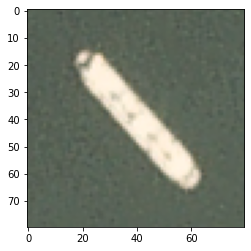

In [9]:
first_image_index_of_ship = np.where(manifest_labels==1)[0][0]
print(f'The first image of a ship is index {first_image_index_of_ship}:')
plt.imshow(dataset[first_image_index_of_ship,:,:,:])

The first image of a non-ship is index 1000:


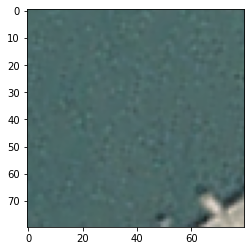

In [10]:
first_image_index_of_non_ship = np.where(manifest_labels==0)[0][0]
print(f'The first image of a non-ship is index {first_image_index_of_non_ship}:')
plt.imshow(dataset[first_image_index_of_non_ship,:,:,:])